In [36]:
using ReadableRegex
using Plots
using Makie, CairoMakie
currentpath = pwd()

"/home/davibarreira/MEGA/EMAp/PlutoLatexConverter.jl"

In [37]:
module Runner
end

Main.Runner

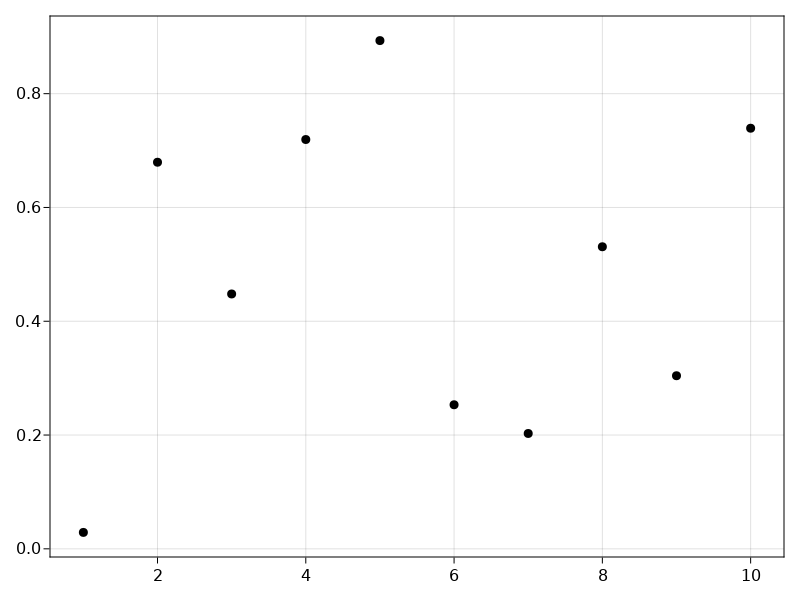

In [38]:
Makie.plot(rand(10))

In [41]:
Makie.save("makie.pdf", Makie.plot(rand(10)))

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x0000000007858610, 600.0, 450.0, IOContext(IOStream(<file /home/davibarreira/MEGA/EMAp/PlutoLatexConverter.jl/makie.pdf>)))


In [3]:
figureindex = 0

0

In [30]:
function extractnotebook(notebook, notebookname=nothing)
    s = read(notebook, String)
    cells = split(s, "# ╔═╡ ");
    # The first cell and the final 3 are not used
    codes, contents, outputtag, celltype = [],[],[],[]
    for cell in cells[2:end-3]
        push!(codes, cell[1:36])
        push!(contents, cell[38:end])
        push!(outputtag, endswith(rstrip(cell),";") ? "hideoutput" : "showoutput")
        push!(celltype, cell[38:42] == "md\"\"\"" ? "markdown" : "code")
    end
    
    # Get order and view type
    r = either("# ╠","# ╟")
    sortedcells = split(cells[end],Regex(r))
    sortedcodes = [cell[4:39] for cell in sortedcells[2:end-2]]
    order = [findfirst(isequal(scode),codes) for scode in  sortedcodes[1:end]]
    view  = [occursin("═",c) ? "showcode" : "hidecode" for c in sortedcells[2:end-2]]
    # Matching running order
    view  = view[order]
    
    if notebookname === nothing
        notebookname = split(notebook,"/")[end]
        if endswith(notebookname,".jl")
            notebookname = notebookname[1:end-3]
        end
    end
    
    notebookdata = Dict(:codes => codes, :notebookname => notebookname,
                        :contents => contents, :outputtag=>outputtag,
                        :celltype => celltype,:order=> order,:view=>view)
    return notebookdata
end

extractnotebook (generic function with 2 methods)

In [31]:
function collectoutputs(nb, notebookfolder="./")
    runpath = pwd()
    cd(notebookfolder)
    outputs = []
    for (i, content) ∈ enumerate(nb[:contents])
        if nb[:celltype][i] == "code"
            if startswith(lstrip(content),"begin") && endswith(rstrip(content),"end")
                ex = :($(Meta.parse(strip(content))))
            else
                ex = :($(Meta.parse("begin\n"*content*"\nend")))
            end
            
            s = string(ex.args[end])
            if contains(s, Regex(either("PlutoUI.LocalResource","LocalResource")))
                imagepath = s[findfirst(Regex(look_for(one_or_more(ANY),after="(",before=")")),s)]
                push!(outputs,("imagepath",imagepath))
            else
                println(nb[:contents][i])
                io = IOBuffer();
                Base.invokelatest(show,IOContext(io, :limit => true),
                    "text/plain", dispatch_output(Runner.eval(ex), nb[:notebookname]));
                celloutput = String(take!(io))
                if celloutput == "nothing"
                    celloutput = ""
                elseif startswith(celloutput, "Plot{Plots.")
                    celloutput = ""
                end
                push!(outputs, celloutput)
            end
        end
    end
    cd(runpath)
    return outputs
end

function dispatch_output(command_eval::Plots.Plot, notebookname)
    global figureindex+=1
    savefig(command_eval,notebookname*"_"*"figure"*string(figureindex)*".png")
    return command_eval
end

function dispatch_output(command_eval, notebookname)
   return command_eval 
end

dispatch_output (generic function with 4 methods)

In [44]:
outputs[end]
push!(outputs,nothing)

8-element Vector{Any}:
 ""
 ""
 "3-element Vector{Int64}:\n 10\n 10\n 10"
 "10-element Vector{Float64}:\n 0.21124767748862006\n 0.7691251330545672\n 0.9677332571235118\n 0.052072067511639064\n 0.706089010978741\n 0.39766668742808053\n 0.8329215036951392\n 0.3002323484772009\n 0.28646206505405214\n 0.6562981028922095"
 "10-element Vector{Float64}:\n 1.21124767748862\n 1.7691251330545672\n 1.9677332571235118\n 1.052072067511639\n 1.706089010978741\n 1.3976666874280805\n 1.8329215036951392\n 1.300232348477201\n 1.2864620650540521\n 1.6562981028922095"
 ("imagepath", "\"figure.svg\"")
 ("imagepath", "\"plotexample.png\"")
 nothing

In [49]:
typeof(outputs[end-1]) <: Tuple

true

In [32]:
example = "./example/examplepluto.jl"
nb = extractnotebook(example)

Dict{Symbol, Any} with 7 entries:
  :codes        => Any["7b4b693d-c955-4c9b-97e8-56d28cf74e18", "bdad72d3-5744-4…
  :outputtag    => Any["showoutput", "showoutput", "showoutput", "showoutput", …
  :celltype     => Any["code", "code", "markdown", "code", "code", "code", "cod…
  :view         => ["showcode", "showcode", "showcode", "showcode", "showcode",…
  :order        => [3, 1, 2, 4, 5, 6, 7, 8]
  :notebookname => "examplepluto"
  :contents     => Any["using PlutoUI\n\n", "\n\t begin\n\tusing Plots\n\ty(x) …

In [33]:
cd(currentpath)
outputs = collectoutputs(nb,"./example/");

using PlutoUI



	 begin
	using Plots
	y(x) = sin(x)
	plot(y,
		color=:blue)
end



A = [10,10,10]


x = rand(10);


x .+ 1




In [29]:
outputs

7-element Vector{Any}:
 ""
 ""
 "3-element Vector{Int64}:\n 10\n 10\n 10"
 "10-element Vector{Float64}:\n 0.011484090200442054\n 0.01820331571644096\n 0.5318877331618481\n 0.11651410662386796\n 0.1890888653818048\n 0.5285985305739234\n 0.37688298409874244\n 0.07979615914345284\n 0.5463733032020945\n 0.5411381912886879"
 "10-element Vector{Float64}:\n 1.011484090200442\n 1.018203315716441\n 1.5318877331618481\n 1.116514106623868\n 1.1890888653818048\n 1.5285985305739234\n 1.3768829840987424\n 1.0797961591434528\n 1.5463733032020945\n 1.541138191288688"
 ("imagepath", "\"figure.svg\"")
 ("imagepath", "\"plotexample.png\"")